<a href="https://colab.research.google.com/github/profitter261/Garbage-Image-Classification-Using-DL/blob/main/waste_garbage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [ ]:
!pip install opendatasets

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from collections import Counter
import random
import cv2
import numpy as np
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0, VGG16, DenseNet121

# Loading Dataset and pre-processing

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification?utm_source=chatgpt.com&select=Garbage+classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arv03arv
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification


100%|██████████| 82.0M/82.0M [00:00<00:00, 1.02GB/s]

In [ ]:
import os
os.listdir("/content/garbage-classification/Garbage classification/Garbage classification")

['trash', 'plastic', 'glass', 'metal', 'paper', 'cardboard']

# Cleaning, preproccessing and Test-Train split

In [ ]:
import os

DATA_DIR = "/content/garbage-classification/Garbage classification/Garbage classification"  # adjust path

valid_ext = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]

for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        if not f.lower().endswith(tuple(valid_ext)):
            print("Removing invalid file:", os.path.join(root, f))
            os.remove(os.path.join(root, f))

In [ ]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


# Normalize pixel values

In [ ]:
normalize = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalize(x), y))
val_ds = val_ds.map(lambda x, y: (normalize(x), y))

# Augment images with rotation, flipping, zoom, etc

In [ ]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])
train_ds = train_ds.map(lambda x, y: (augmentation(x, training=True), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Addressing class imbalance

In [ ]:
from collections import Counter
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

counts = Counter(all_labels)
total = sum(counts.values())
num_classes = len(counts)
class_weights = {cls: total / (num_classes * count) for cls, count in counts.items()}

print("Class distribution:", counts)
print("Class weights:", class_weights)

Class distribution: Counter({3: 471, 1: 399, 4: 393, 0: 334, 2: 322, 5: 103})
Class weights: {3: 0.7154989384288747, 1: 0.8446115288220551, 5: 3.2718446601941746, 2: 1.046583850931677, 0: 1.0089820359281436, 4: 0.8575063613231552}


In [ ]:
class_counts = {}
for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))])

# Exploratory Data Analysis (EDA)

## Number of images per class

Number of images per class: {'trash': 137, 'plastic': 482, 'glass': 501, 'metal': 410, 'paper': 594, 'cardboard': 403}


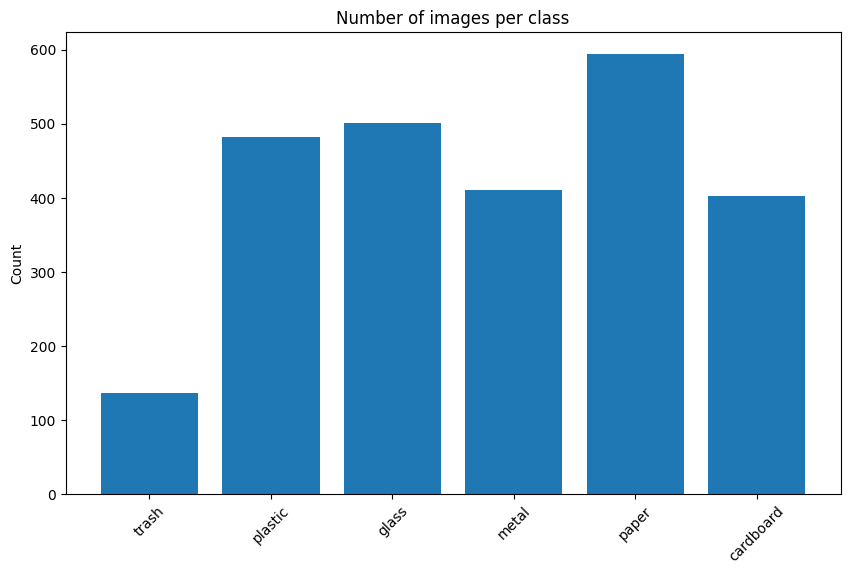

In [ ]:
print("Number of images per class:", class_counts)

# Bar chart
plt.figure(figsize=(10,6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Number of images per class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Example images from each category

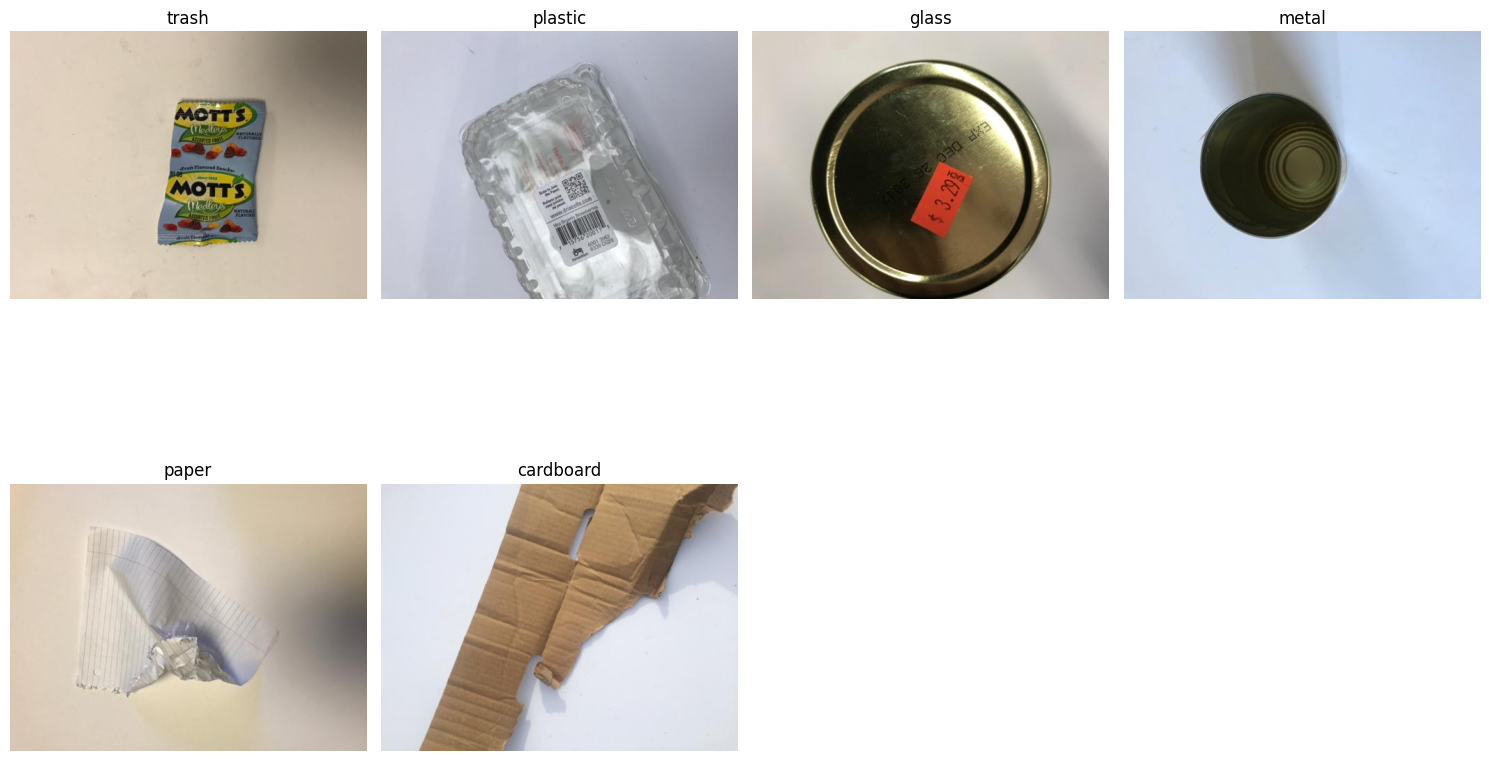

In [ ]:
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_counts.keys()):
    class_path = os.path.join(DATA_DIR, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))]
    sample_img = random.choice(img_files)
    img = cv2.imread(os.path.join(class_path, sample_img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, len(class_counts)//2 + 1, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

## Pixel intensity or Color distribution

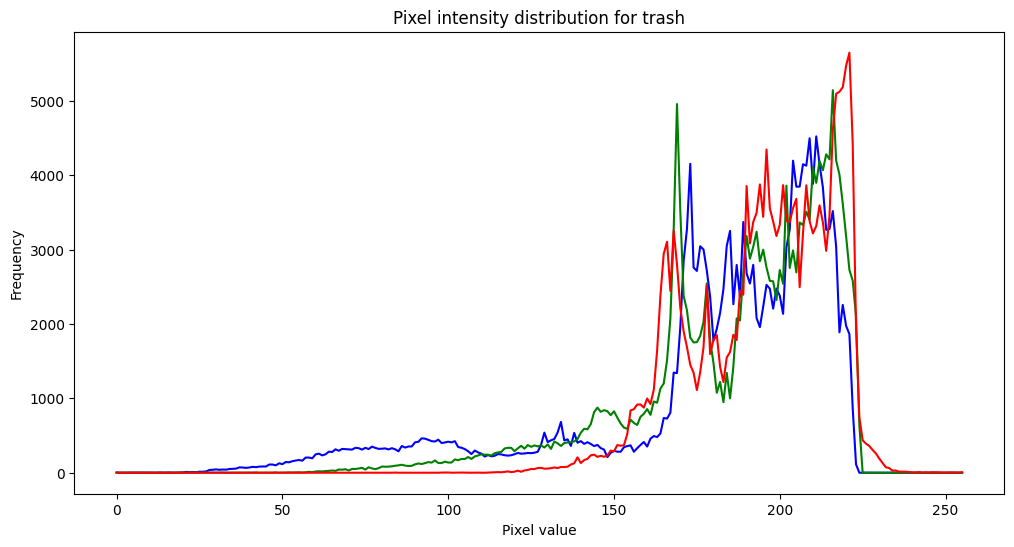

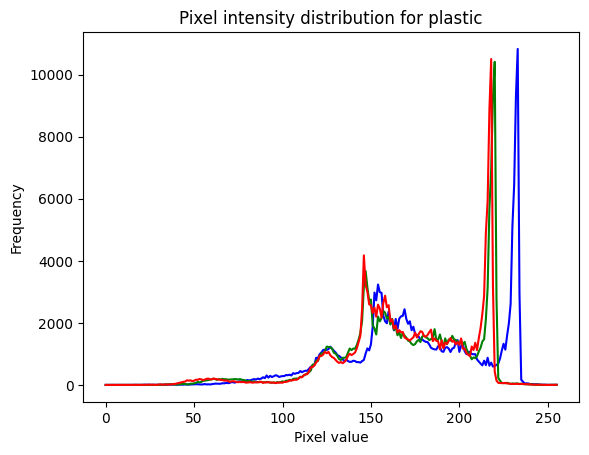

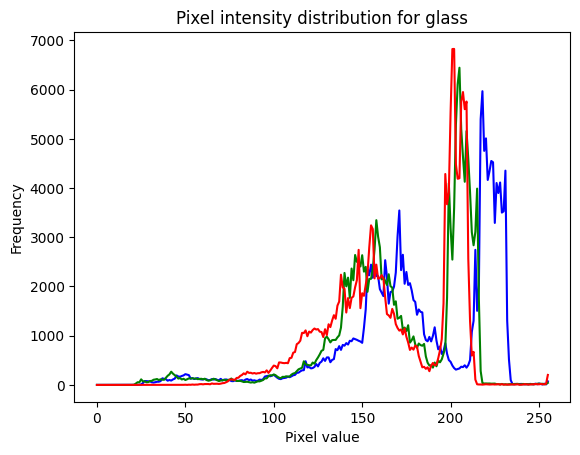

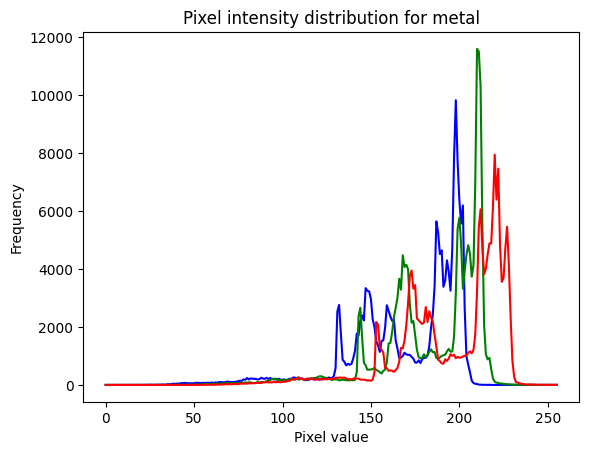

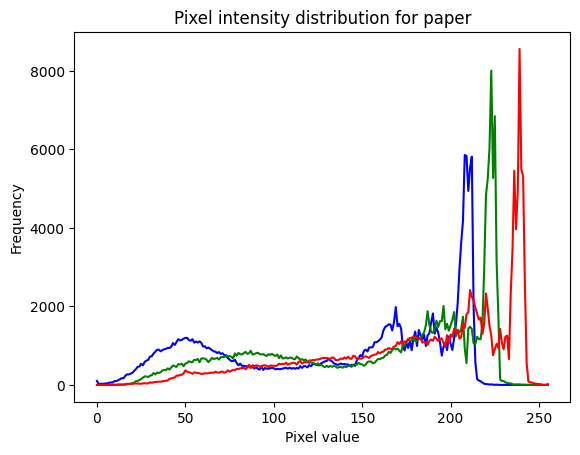

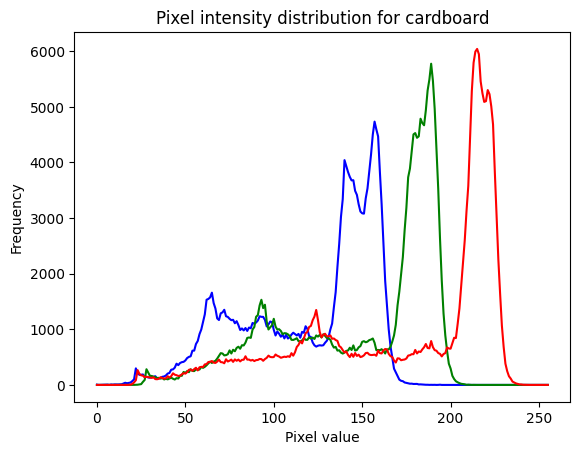

In [ ]:
plt.figure(figsize=(12,6))
colors = ('b','g','r')
for class_name in class_counts.keys():
    class_path = os.path.join(DATA_DIR, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))]
    sample_img = cv2.imread(os.path.join(class_path, random.choice(img_files)))

    for i, col in enumerate(colors):
        hist = cv2.calcHist([sample_img],[i],None,[256],[0,256])
        plt.plot(hist, color=col)
    plt.title(f"Pixel intensity distribution for {class_name}")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.show()

# Model Development

##  Transfer Learning

In [ ]:
# ===========================
# Dataset paths
# ===========================
DATA_DIR = "/content/garbage-classification/Garbage classification/Garbage classification"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ===========================
# Function to create model
# ===========================
def create_model(base_model_name):
    if base_model_name == "ResNet50":
        base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE,3))
    elif base_model_name == "MobileNetV2":
        base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE,3))
    elif base_model_name == "EfficientNetB0":
        base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE,3))
    elif base_model_name == "VGG16":
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE,3))
    elif base_model_name == "DenseNet121":
        base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE,3))
    else:
        raise ValueError("Unknown model name")

    base_model.trainable = False  # freeze base layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])
    return model

# ===========================
# Example: create and compile ResNet50 model
# ===========================
model = create_model("ResNet50")
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
import os
from PIL import Image

DATA_DIR = "/content/garbage-classification/Garbage classification/Garbage classification"  # adjust your path
valid_files = []

for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        file_path = os.path.join(root, f)
        try:
            img = Image.open(file_path)
            img.verify()  # verify if image can be opened
            valid_files.append(file_path)
        except (IOError, SyntaxError) as e:
            print("Removing invalid/corrupted file:", file_path)
            os.remove(file_path)

In [ ]:
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step


# Model Evaluation and Best Model Selection

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

🔹 Training ResNet50 (frozen base)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 500s 7s/step - accuracy: 0.2361 - loss: 1.8713 - val_accuracy: 0.3101 - val_loss: 1.6599
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 457s 7s/step - accuracy: 0.2630 - loss: 1.7000 - val_accuracy: 0.3101 - val_loss: 1.6393
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 453s 7s/step - accuracy: 0.2723 - loss: 1.6715 - val_accuracy: 0.3042 - val_loss: 1.6486

✅ ResNet50 Evaluation Metrics:
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        80
       glass       0.00      0.00      0.00       100
       metal       0.43      0.12      0.19        82
       paper       0.58      0.42      0.49       118
     plastic       0.24      0.97      0.38        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.30       503
   macro avg       0.21      0.25      0.18       503
weighted avg       0.25      0.30      0.22       503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


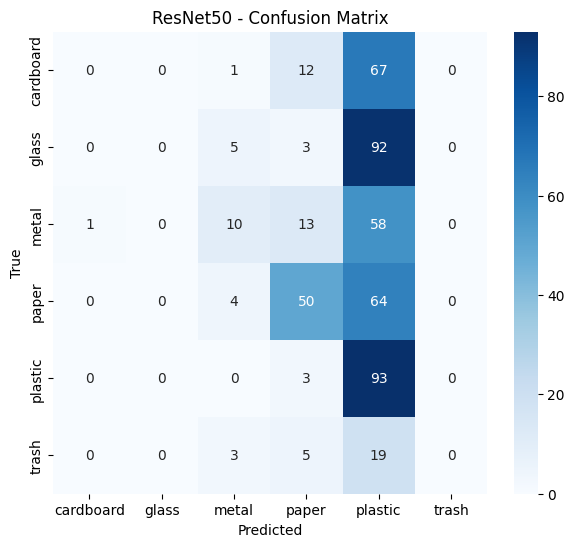

ResNet50 Final Validation Accuracy (for comparison): 0.3042

🔹 Training EfficientNetB0 (frozen base)...
Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.1945 - loss: 1.7760 - val_accuracy: 0.1909 - val_loss: 1.7351
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.1984 - loss: 1.7560 - val_accuracy: 0.2346 - val_loss: 1.7241
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.2145 - loss: 1.7407 - val_accuracy: 0.1988 - val_loss: 1.7334

✅ EfficientNetB0 Evaluation Metrics:
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        80
       glass       0.20      1.00      0.33       100
       metal       0.00      0.00      0.00        82
       paper       0.00      0.00      0.00       118
     plastic       0.00      0.00      0.00        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.20       503
   macro avg       0.03      0.17      0.06   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


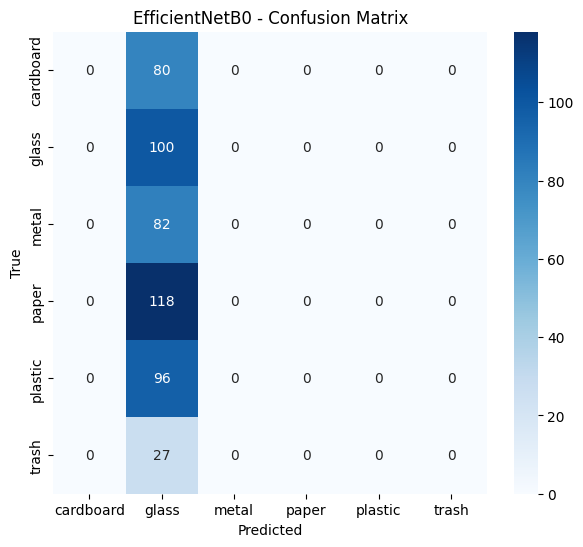

EfficientNetB0 Final Validation Accuracy (for comparison): 0.1988

🔹 Training MobileNetV2 (frozen base)...
Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.3908 - loss: 1.5507 - val_accuracy: 0.6382 - val_loss: 0.8818
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7187 - loss: 0.7500 - val_accuracy: 0.6998 - val_loss: 0.7837
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7720 - loss: 0.6078 - val_accuracy: 0.7316 - val_loss: 0.6723

✅ MobileNetV2 Evaluation Metrics:
              precision    recall  f1-score   support

   cardboard       0.92      0.75      0.83        80
       glass       0.65      0.70      0.68       100
       metal       0.75      0.78      0.77        82
       paper       0.75      0.91      0.82       118
     plastic       0.66      0.59      0.62        96
       trash       0.59      0.37      0.45        27

    accuracy                           0.73       503
   macro avg       0.72      0.68      0.70   

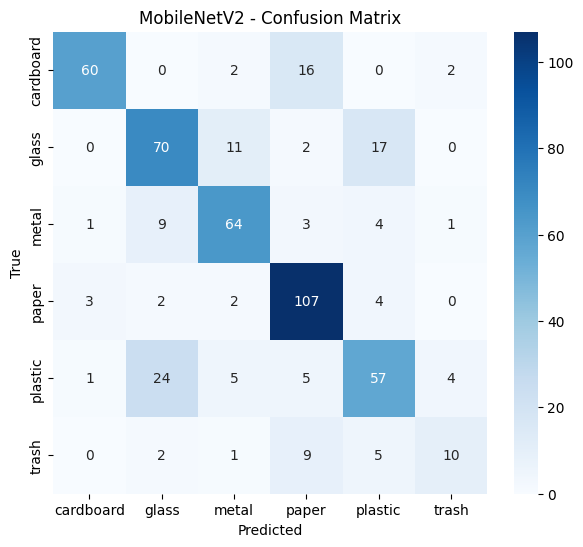

MobileNetV2 Final Validation Accuracy (for comparison): 0.7316

🔹 Training DenseNet121 (frozen base)...
Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 473s 7s/step - accuracy: 0.3200 - loss: 1.7987 - val_accuracy: 0.6044 - val_loss: 1.0365
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 490s 7s/step - accuracy: 0.6601 - loss: 0.9388 - val_accuracy: 0.6998 - val_loss: 0.8553
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 440s 7s/step - accuracy: 0.7213 - loss: 0.7816 - val_accuracy: 0.7038 - val_loss: 0.7614

✅ DenseNet121 Evaluation Metrics:
              precision    recall  f1-score   support

   cardboard       0.85      0.71      0.78        80
       glass       0.61      0.69      0.64       100
       metal       0.70      0.68      0.69        82
       paper       0.78      0.91      0.84       118
     plastic       0.66      0.58      0.62        96
       trash       0.45      0.33      0.38        27

    accuracy                           0.70       503
   macro avg       0.67      0.65      0.66      

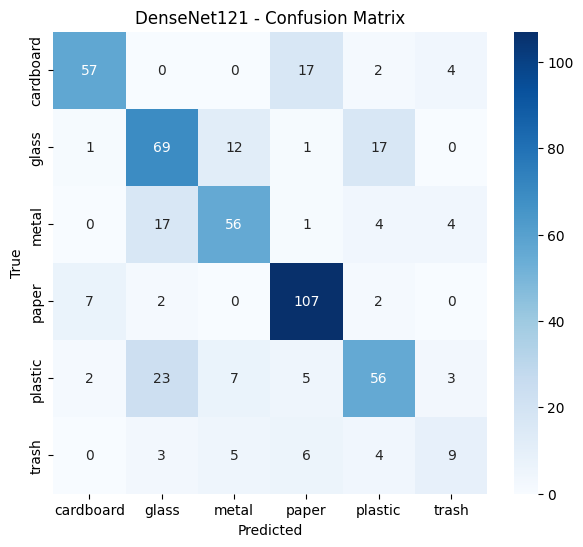

DenseNet121 Final Validation Accuracy (for comparison): 0.7038

🔹 Training InceptionV3 (frozen base)...
Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.4411 - loss: 1.4656 - val_accuracy: 0.7316 - val_loss: 0.7750
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 317s 5s/step - accuracy: 0.7498 - loss: 0.6942 - val_accuracy: 0.7276 - val_loss: 0.7121
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.7966 - loss: 0.5567 - val_accuracy: 0.7734 - val_loss: 0.6458

✅ InceptionV3 Evaluation Metrics:
              precision    recall  f1-score   support

   cardboard       0.94      0.76      0.84        80
       glass       0.77      0.77      0.77       100
       metal       0.68      0.82      0.74        82
       paper       0.75      0.92      0.83       118
     plastic       0.81      0.69      0.75        96
       trash       0.64      0.33      0.44        27

    accuracy                           0.77       503
   macro avg       0.77      0.72      0.73      

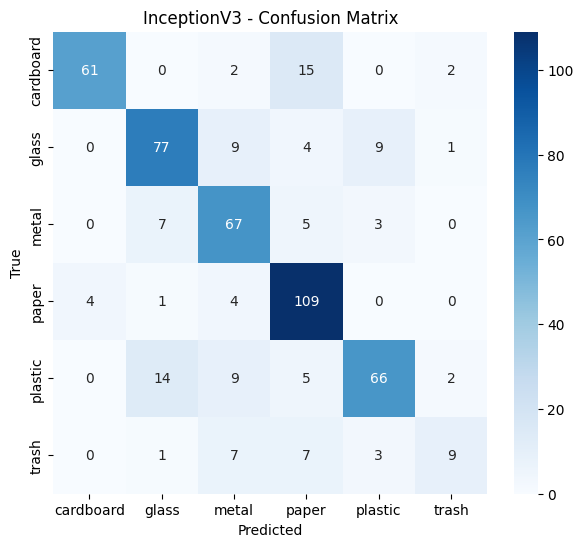

InceptionV3 Final Validation Accuracy (for comparison): 0.7734

Best backbone for your dataset is: InceptionV3
Validation Accuracies: {'ResNet50': 0.3041749596595764, 'EfficientNetB0': 0.19880715012550354, 'MobileNetV2': 0.7316103577613831, 'DenseNet121': 0.7037773132324219, 'InceptionV3': 0.7733598351478577}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2, DenseNet121, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 1. Load dataset (single folder with subfolders for each class)
# ================================
data_dir = "/content/garbage-classification/Garbage classification/Garbage classification"  # your folder containing 6 class subfolders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False  # important for consistent evaluation
)

NUM_CLASSES = len(train_gen.class_indices)
CLASS_NAMES = list(train_gen.class_indices.keys())

# ================================
# 2. Function to build a model
# ================================
def build_model(base_model, num_classes):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    preds = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=preds)

# ================================
# 3. Candidate models
# ================================
candidates = {
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,)),
    "EfficientNetB0": EfficientNetB0(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,)),
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,)),
    "DenseNet121": DenseNet121(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,)),
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
}

results = {}

# ================================
# 4. Training & evaluation loop
# ================================
for name, base in candidates.items():
    print(f"\n🔹 Training {name} (frozen base)...")
    model = build_model(base, NUM_CLASSES)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Quick training
    history = model.fit(
        train_gen,
        epochs=3,
        validation_data=val_gen,
        verbose=1
    )

    # Predictions on validation set
    val_gen.reset()
    y_true = val_gen.classes
    y_pred_prob = model.predict(val_gen, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Metrics
    print(f"\n✅ {name} Evaluation Metrics:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Save overall accuracy for comparison
    val_acc = history.history["val_accuracy"][-1]
    results[name] = val_acc
    print(f"{name} Final Validation Accuracy (for comparison): {val_acc:.4f}")

# ================================
# 5. Pick the best model
# ================================
best_model = max(results, key=results.get)
print("\n===================================")
print("Best backbone for your dataset is:", best_model)
print("Validation Accuracies:", results)
print("===================================")
